In [1]:
#stdlib
import os
import sys
import math
import datetime as dt
import functools
import itertools
import collections
import subprocess

# 3rd party
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Config
pd.set_option('display.max_columns', None)

## Load your data below:
Data must have 'sequence' column of uppercase letters and 'label' column (int). 
`name` is a variable corresponding to what your label does.

In [2]:
df = pd.read_csv('data/acp/train_data.csv').rename(columns={'sequences': 'sequence'})
name = 'ACP'

In [3]:
df.describe()

,label
count,1378.000000
mean,0.500000
std,0.500182
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


These are real CSVs, not fasta, unlike most protein data.

In [4]:
df['label'].value_counts()

0    689
1    689
Name: label, dtype: int64

### Count Unique Characters per protein

<AxesSubplot:xlabel='unique_characters', ylabel='Density'>

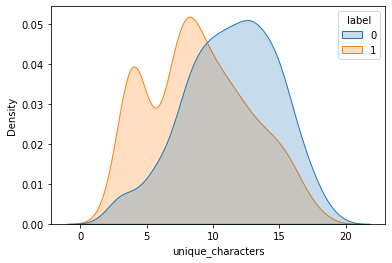

In [5]:
df['unique_characters'] = df['sequence'].apply(lambda x: len(np.unique([*x])))
sns.kdeplot(data=df, x='unique_characters', hue='label', common_norm=True, shade=True)

## Count length of sequence per protein
We also add log sequence length in case the distribution is lognormal.

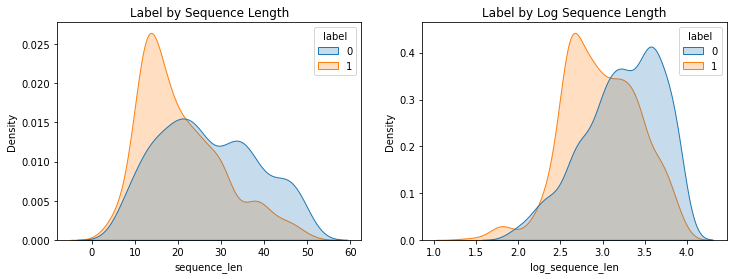

In [6]:
_fig, axes = plt.subplots(1, 2, figsize=(12, 4))
df['sequence_len'] = df['sequence'].str.len()
df['log_sequence_len'] = np.log(1 + df['sequence_len'])
sns.kdeplot(data=df, x='sequence_len', hue='label', shade=True, ax=axes[0]).set_title('Label by Sequence Length')
sns.kdeplot(data=df, x='log_sequence_len', hue='label', shade=True, ax=axes[1]).set_title('Label by Log Sequence Length')
pass

## Amino acid count
Again, this is may be a lognormal distribution so we show the logs as well.

In [7]:
all_chars = sorted(set(df[['sequence']].applymap(list).sequence.apply(pd.Series).stack().unique()))
f'There are {len(all_chars)} unique amino acid characters in data.'

'There are 20 unique amino acid characters in data.'

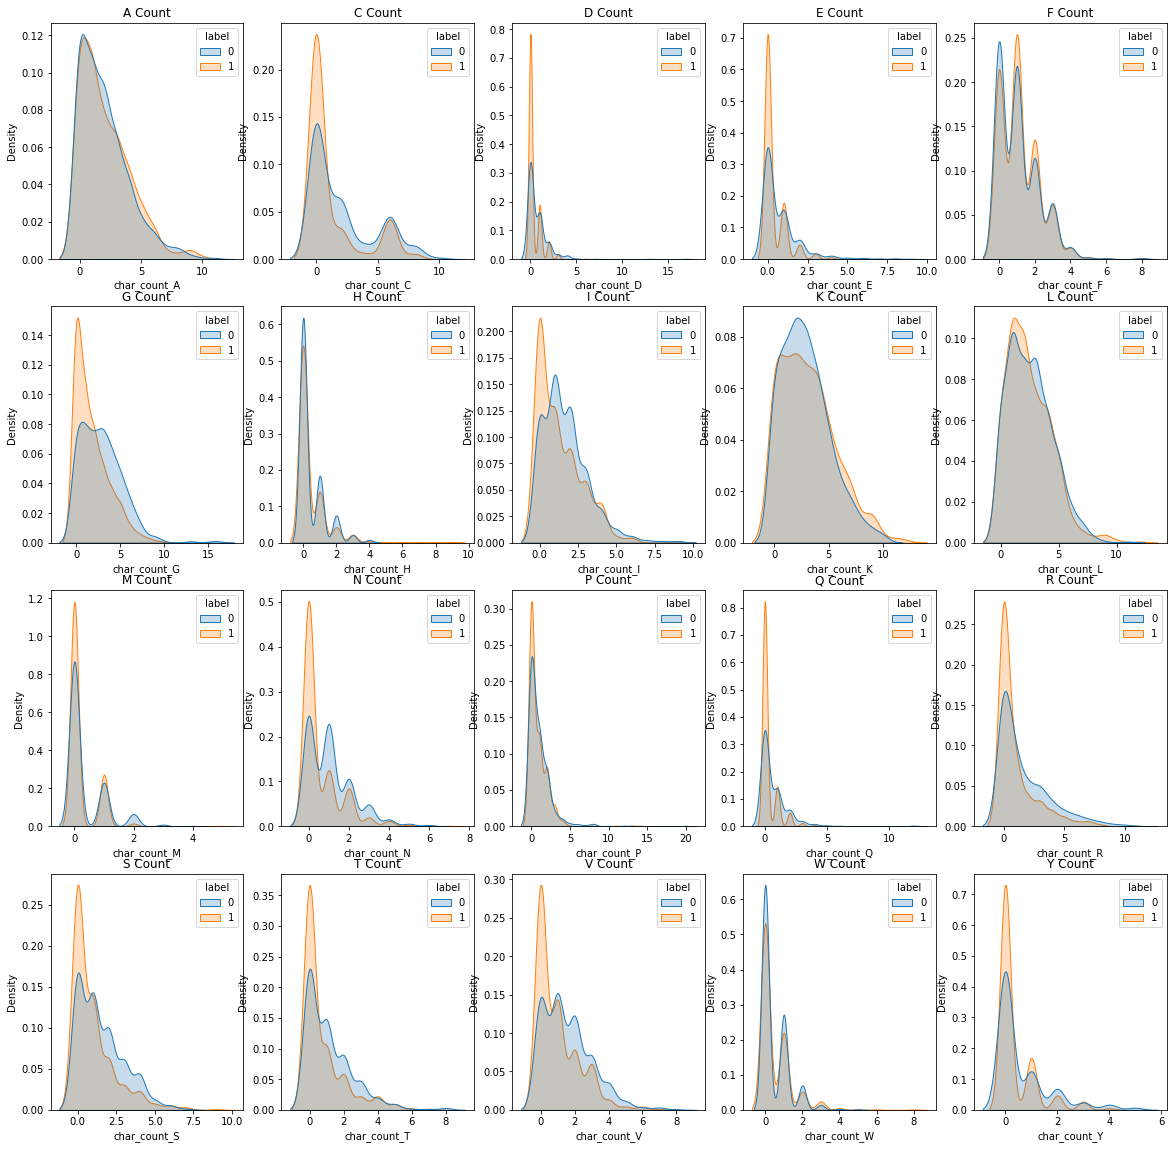

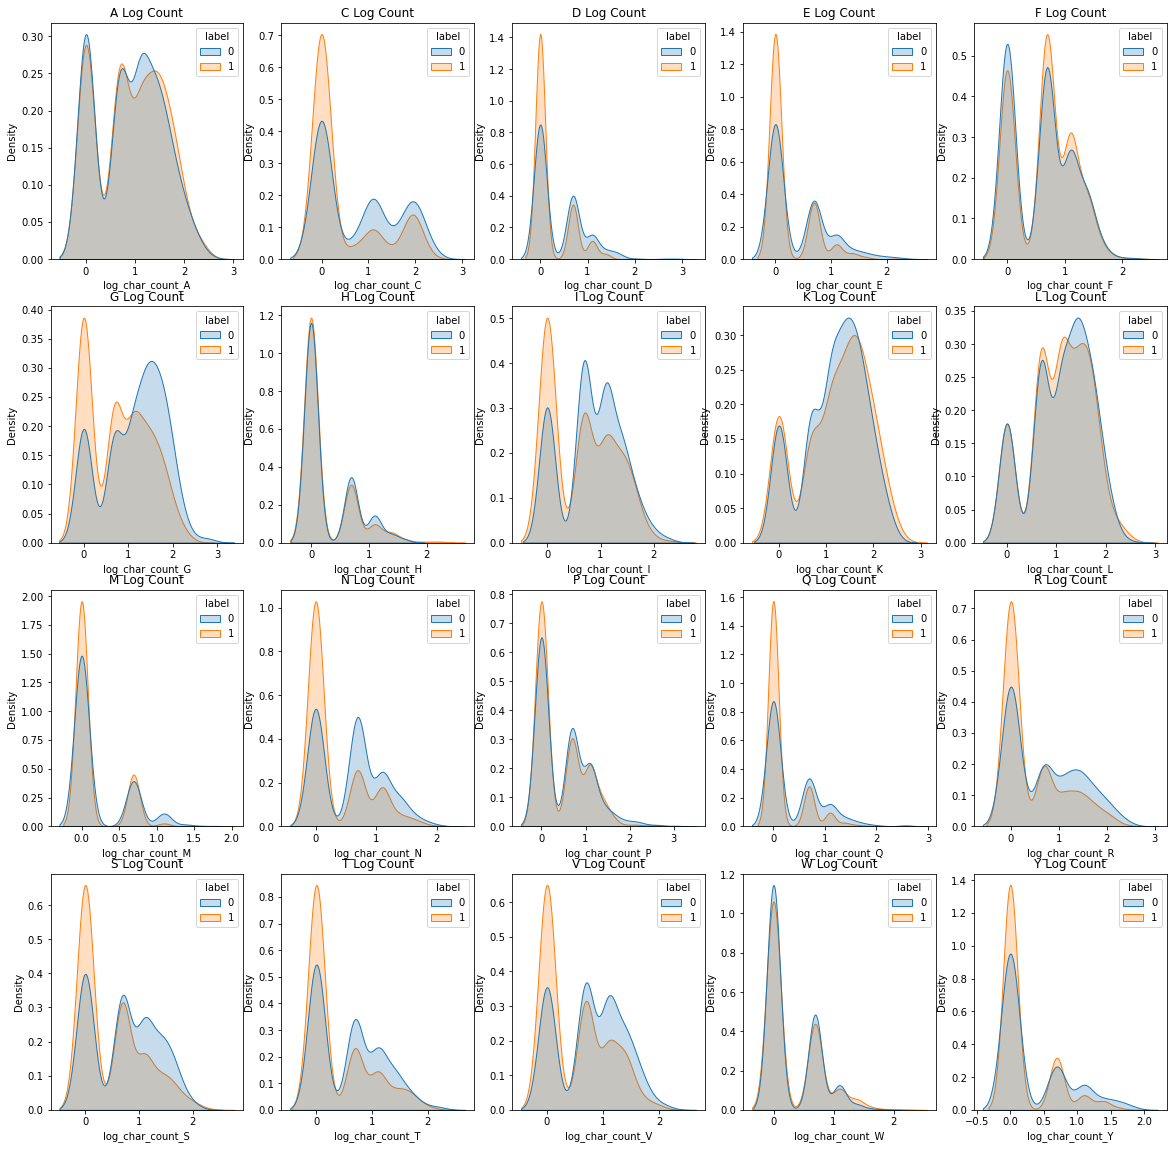

In [8]:
for char in sorted(all_chars):
    df[f'char_count_{char}'] = df['sequence'].str.count(char)
    df[f'log_char_count_{char}'] = np.log(1 + df[f'char_count_{char}'])
fig, axs = plt.subplots(math.ceil(len(all_chars) / 5), 5, figsize=(20, max(20, len(all_chars))))
axs = axs.ravel()  # To deal with rows of plots
for i, char in enumerate(all_chars):
    sns.kdeplot(data=df, x=f'char_count_{char}', hue='label', warn_singular=False, shade=True, ax=axs[i]).set_title(f'{char} Count')
plt.show()
fig, axs = plt.subplots(math.ceil(len(all_chars) / 5), 5, figsize=(20, max(20, len(all_chars))))
axs = axs.ravel()  # To deal with rows of plots
for i, char in enumerate(all_chars):
    sns.kdeplot(data=df, x=f'log_char_count_{char}', hue='label', warn_singular=False, shade=True, ax=axs[i]).set_title(f'{char} Log Count')
pass

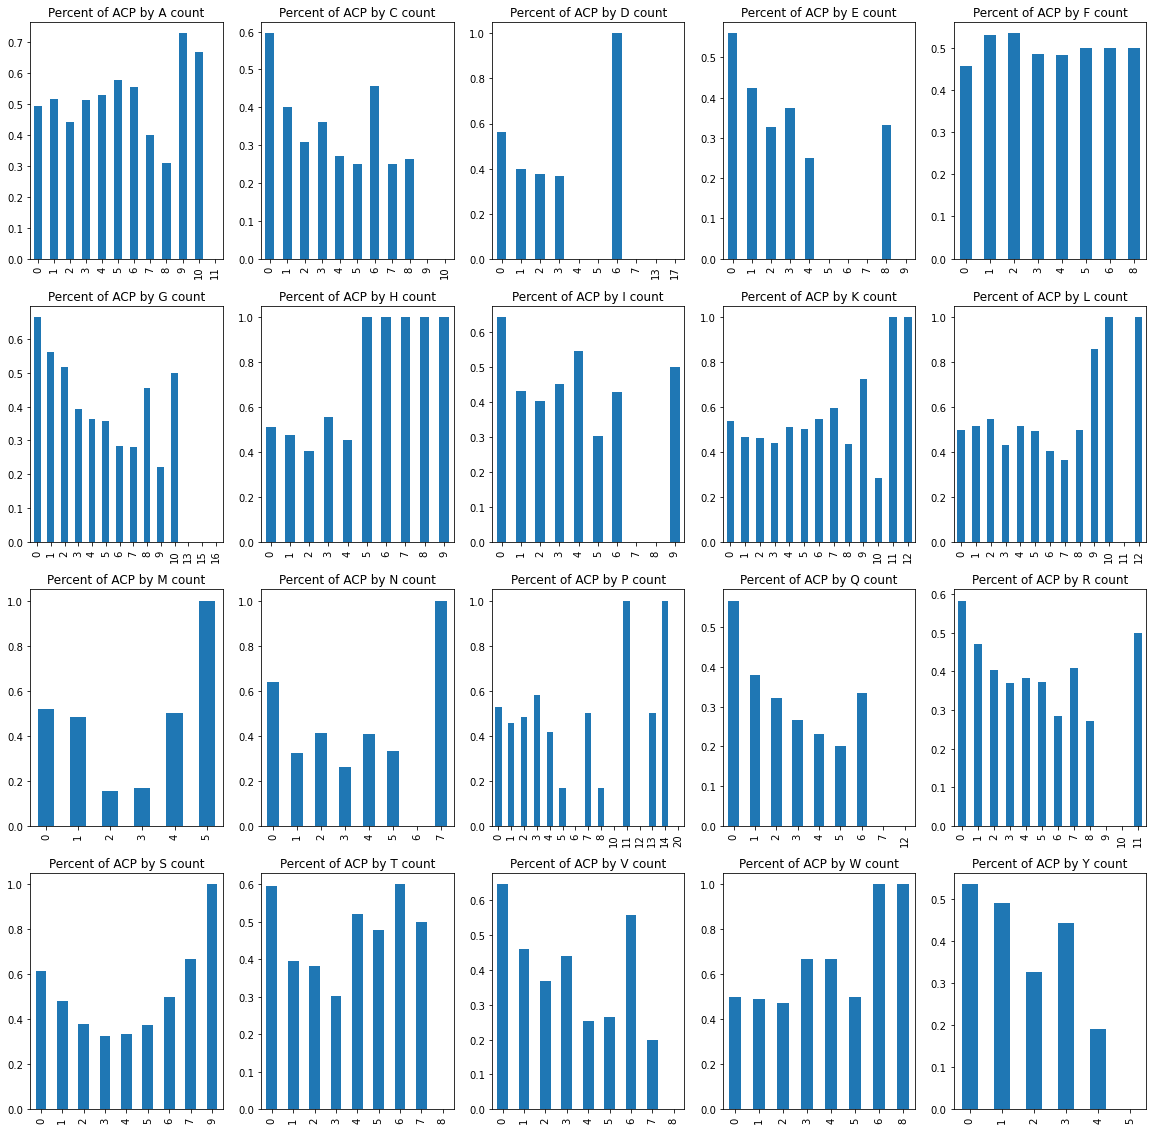

In [11]:
# Percent of ACP by sequence length
fig, axs = plt.subplots(math.ceil(len(all_chars) / 5), 5, figsize=(20, max(20, len(all_chars))))
axs = axs.ravel()  # To deal with rows of plots
for i, char in enumerate(sorted(all_chars)):
    df.groupby(f'char_count_{char}')['label'].mean().plot.bar(ax=axs[i], title=f'Percent of {name} by {char} count', xlabel='')

## Show the top and bottom most correlated columns

/tmp/ipykernel_12633/3650147548.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = df.corr().loc[['label'], :]


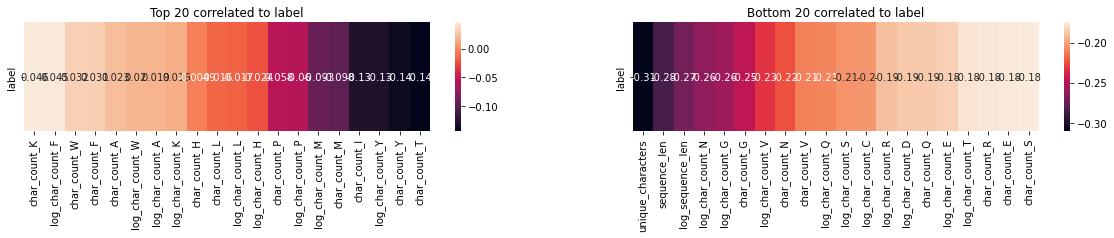

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(20, 2))
max_columns = 20
corr_df = df.corr().loc[['label'], :]
top_corr_df = corr_df[list(reversed(corr_df.columns[corr_df.loc[corr_df.last_valid_index()].argsort()]))[1:max_columns+1]]
sns.heatmap(top_corr_df, annot=True, ax=ax[0]).set_title(f'Top {max_columns} correlated to label')
bot_corr_df = corr_df[list(corr_df.columns[corr_df.loc[corr_df.last_valid_index()].argsort()])[:max_columns]]
sns.heatmap(bot_corr_df, annot=True, ax=ax[1]).set_title(f'Bottom {max_columns} correlated to label')
pass